In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
raw = pd.read_csv("./data/train.csv")

In [3]:
df = raw.copy()

In [4]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
def balanced_logarithmic_loss(y_true, y_pred):
    N = len(y_true)

    # Nc is the number of observations
    N_1 = np.sum(y_true == 1, axis=0)
    N_0 = np.sum(y_true == 0, axis=0)

    # wc prevalence
    prev_w_1 = N_1 / N
    prev_w_0 = N_0 / N

    # wc is equal to the inverse prevalence of c
    w_1 = 1 / prev_w_1
    w_0 = 1 / prev_w_0

    # In order to avoid the extremes of the log function, each predicted probability 𝑝 is replaced with max(min(𝑝,1−10−15),10−15)
    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)

    # balanced logarithmic loss
    loss_numerator = -(w_0 / N_0) * np.sum((1 - y_true) * np.log(1 - y_pred)) - (
        w_1 / N_1
    ) * np.sum(y_true * np.log(y_pred))
    loss_denominator = w_0 + w_1

    return loss_numerator / loss_denominator


In [7]:
# clean features
def clean_features(df: pd.DataFrame) -> pd.DataFrame:
    df["EJ"] = np.where(df["EJ"] == "A", 1, 0)
    df = df.fillna(df.mean(numeric_only=True))
    return df

In [8]:
df = df.pipe(clean_features)

In [9]:
df.isna().sum()

Id       0
AB       0
AF       0
AH       0
AM       0
AR       0
AX       0
AY       0
AZ       0
BC       0
BD       0
BN       0
BP       0
BQ       0
BR       0
BZ       0
CB       0
CC       0
CD       0
CF       0
CH       0
CL       0
CR       0
CS       0
CU       0
CW       0
DA       0
DE       0
DF       0
DH       0
DI       0
DL       0
DN       0
DU       0
DV       0
DY       0
EB       0
EE       0
EG       0
EH       0
EJ       0
EL       0
EP       0
EU       0
FC       0
FD       0
FE       0
FI       0
FL       0
FR       0
FS       0
GB       0
GE       0
GF       0
GH       0
GI       0
GL       0
Class    0
dtype: int64

In [10]:
model = xgb.XGBClassifier(eval_metric="logloss")
X = df.drop(["Id", "Class"], axis=1)  
y = df["Class"]


In [11]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [12]:
# model1 = xgb.XGBClassifier(eval_metric=balanced_logarithmic_loss)

# # fit the model
# model1.fit(X,y)


In [13]:
test = pd.read_csv("./data/test.csv")

In [14]:
test = test.pipe(clean_features)

In [15]:
predictions = model.predict_proba(test.drop(["Id"], axis=1))

In [16]:
# prediction1 = model1.predict_proba(test.drop(["Id"], axis=1))

In [17]:
predictions

array([[0.8919803 , 0.10801969],
       [0.8919803 , 0.10801969],
       [0.8919803 , 0.10801969],
       [0.8919803 , 0.10801969],
       [0.8919803 , 0.10801969]], dtype=float32)

In [18]:
# prediction1

In [19]:
submission = pd.DataFrame({"Id": test["Id"], "class_0": predictions[:, 0], "class_1": predictions[:, 1]})

In [20]:
submission.to_csv("submission.csv", index=False)

In [21]:
#Feature importances
import matplotlib.pyplot as plt
from xgboost import plot_importance

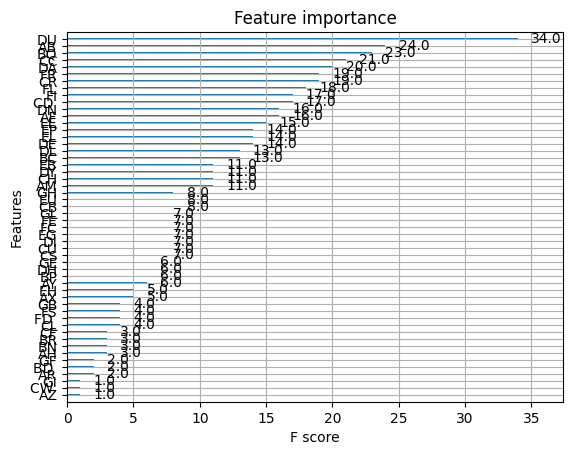

In [25]:
plot_importance(model.get_booster())
plt.show()

In [26]:
# get values of feature importance
importance = model.get_booster().get_score(importance_type="weight")


In [29]:
importance_df = pd.DataFrame(
    sorted(importance.items(), key=lambda x: x[1], reverse=True)
)

In [35]:
importance_df.columns = ["feature", "fscore"]
importance_df

,feature,fscore
0,DU,34.0
1,AB,24.0
2,BQ,23.0
3,CC,21.0
4,DA,20.0
5,CR,19.0
6,FR,19.0
7,FL,18.0
8,CD,17.0
9,FI,17.0


In [36]:
importance_df.loc[importance_df["fscore"] > 10, :].to_csv("feature_importance.csv", index=False)

In [34]:
#get the r2 of the model
from sklearn.metrics import r2_score

r2_score(y, model.predict(X))

1.0